In [7]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# # Load the dataset
# file_path = 'dataset.csv'
# data = pd.read_csv(file_path)

# # Convert the 'Date' column to datetime
# data['Date'] = pd.to_datetime(data['Date'])

# # Set 'Date' as the index
# data.set_index('Date', inplace=True)

# # Display the first few rows of the dataset and the data types of each column
# print(data.head())
# print(data.dtypes)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\USER\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\USER\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "C:\Users\USER\anaconda3\Lib\site-packages\

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

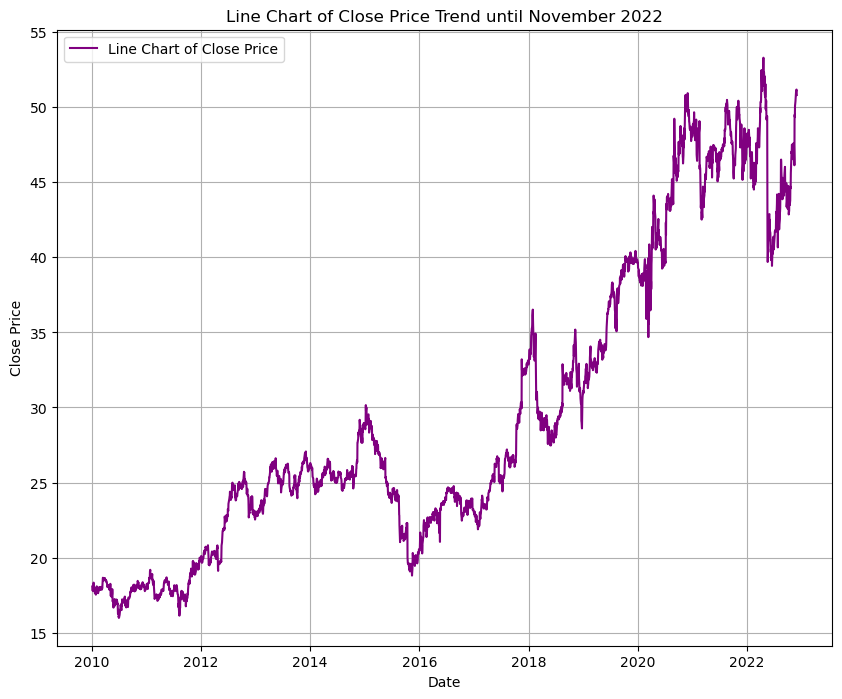

In [76]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='purple')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Model

In [ ]:
# Scaling the data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the training and validation data for LSTM
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include the last 60 days of training data for context

# Create sequences for training
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to be suitable for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting 1 value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test))


# Make predictions on the test data
predicted_scaled = model.predict(X_test)

# Inverse transform to get the actual values
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Filter the data for December 2022 only
december_start = '2022-12-01'
december_end = '2022-12-30'
december_mask = (data.index >= december_start) & (data.index <= december_end)

# Filter the actual and predicted values for December 2022
december_dates = data.index[december_mask]
predicted_december = predicted[-len(december_dates):]
y_test_december = y_test_actual[-len(december_dates):]

# Plotting the LSTM predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(december_dates, y_test_december, label='Actual Close Price', color='red', marker='o')
plt.plot(december_dates, predicted_december, label='LSTM Predicted Close Price', color='green', marker='o')
plt.title('LSTM Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(december_dates, y_test_december.flatten(), predicted_december.flatten(), 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


Epoch 1/60


C:\Users\zains\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 2/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 3.2671e-04 - val_loss: 0.0014
Epoch 3/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.8394e-04 - val_loss: 0.0015
Epoch 4/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.9253e-04 - val_loss: 0.0012
Epoch 5/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.8065e-04 - val_loss: 0.0012
Epoch 6/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.7185e-04 - val_loss: 0.0011
Epoch 7/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.3983e-04 - val_loss: 0.0012
Epoch 8/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 2.5682e-04 - val_loss: 9.4022e-04
Epoch 9/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 2.2224e-04 - val_loss: 0.0013
Epoch 10/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 2.1676e-04 - val_loss: 8.1702e-04
Epoch 11/60
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.0843e-04 - val_loss: 9.3358e-04
Epoch 12/60
80/80 ━━━━

# ARIMA Model

In [ ]:
# Fit the ARIMA model
arima_model = ARIMA(data['Close'], order=(6, 2, 0))    #   autoregressive terms (AR), differencing term (I), and 0 moving average terms (MA)
arima_model_fit = arima_model.fit()

# Create a future dataframe for December 2022 for ARIMA
start = '2022-12-01'
end = '2022-12-30'
arima_forecast = arima_model_fit.predict(start=start, end=end, dynamic=False)


In [ ]:
# Plotting the ARIMA predictions vs actual values for December 2022
plt.figure(figsize=(10, 8))
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(december_dates, data['Close'][december_mask], label='Actual Close Price', color='red', marker='o')
plt.title('ARIMA Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(arima_forecast.index, data['Close'][december_mask], arima_forecast, 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# Prophet Model

In [ ]:
# Prepare data for Prophet
prophet_data = data.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create future dataframe & Generate forecasts
future_dates = prophet_model.make_future_dataframe(periods=30)  # Predict up to December 2022
prophet_forecast = prophet_model.predict(future_dates)

# Filter the forecast for December 2022
prophet_december = prophet_forecast[(prophet_forecast['ds'] >= '2022-12-01') & 
                                     (prophet_forecast['ds'] <= '2022-12-30')]

# Plotting the Prophet predictions
plt.figure(figsize=(10, 8))
plt.plot(data.loc['2022-12-01':'2022-12-30'].index, data['Close']['2022-12-01':'2022-12-30'], 
         label='Actual Close Price', color='red', marker='o')
plt.plot(prophet_december['ds'], prophet_december['yhat'], 
         label='Prophet Predicted Close Price', color='green', marker='o')

# Highlight the difference using a grey fill
plt.fill_between(prophet_december['ds'], data['Close']['2022-12-01':'2022-12-30'], 
                 prophet_december['yhat'], color='gray', alpha=0.2, label='Difference')

plt.title('Prophet Model - Actual vs Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

# Save Prophet predictions for the comparison
prophet_predictions = prophet_december[['ds', 'yhat']].set_index('ds')


# Comparison of Actual and Predicted Values

In [ ]:
# Filter the actual close prices for December 2022
december_mask = (data.index >= '2022-12-01') & (data.index <= '2022-12-30')
actual_dec_2022 = data.loc[december_mask]

# Merge actual and ARIMA predictions for December 2022
combined_df = actual_dec_2022[['Close']].join(arima_forecast.rename('ARIMA'), how='inner')

# Add LSTM predictions to the combined DataFrame
combined_df['LSTM'] = predicted_december  # Ensure this variable contains predictions for December

# Add Prophet predictions to the combined DataFrame
combined_df['Prophet'] = prophet_predictions['yhat'].values  # Make sure you have 'yhat' for Prophet predictions

# Plotting the combined data
plt.figure(figsize=(10, 8))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(combined_df.index, combined_df['ARIMA'], label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(combined_df.index, combined_df['LSTM'], label='LSTM Predicted Close Price', color='purple', marker='o')
plt.plot(combined_df.index, combined_df['Prophet'], label='Prophet Predicted Close Price', color='orange', marker='o')
plt.title('Actual vs ARIMA, LSTM, and Prophet Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

plt.legend()
plt.grid(True)
plt.show()


# Error Metrics

In [ ]:
# Calculate and display error metrics for LSTM model for December 2022
mse_lstm = mean_squared_error(actual_dec_2022['Close'], combined_df['LSTM'])
mae_lstm = mean_absolute_error(actual_dec_2022['Close'], combined_df['LSTM'])

print(f'LSTM Mean Squared Error for December 2022: {mse_lstm}')
print(f'LSTM Mean Absolute Error for December 2022: {mae_lstm}')

# Calculate and display error metrics for ARIMA model for December 2022
mse_arima = mean_squared_error(actual_dec_2022['Close'], combined_df['ARIMA'])
mae_arima = mean_absolute_error(actual_dec_2022['Close'], combined_df['ARIMA'])

print(f'ARIMA Mean Squared Error for December 2022: {mse_arima}')
print(f'ARIMA Mean Absolute Error for December 2022: {mae_arima}')

# Calculate and display error metrics for Prophet model for December 2022
mse_prophet = mean_squared_error(actual_dec_2022['Close'], combined_df['Prophet'])
mae_prophet = mean_absolute_error(actual_dec_2022['Close'], combined_df['Prophet'])

print(f'Prophet Mean Squared Error for December 2022: {mse_prophet}')
print(f'Prophet Mean Absolute Error for December 2022: {mae_prophet}')
